# Модель прогноза лесных рубок по разновременным космоснимкам

Исследование проведено в два этапа. На первом этапе определялась относительное изменение значений спектральных каналов Sentinel-2 вследствие проведения вырубки леса. На втором этапе дана оценка результатов машинного обучения при различных исследовательских сценариях.

**1 этап. Анализ влияния рубок на средние значения каналов**

Для исследования подготовлена выборка данных на основе 29 рубок, произошедших в период между двумя снимками Sentinel-2, с датами съемки 12.07.2017 и 21.08.2017. Использовано по 9 каналов от каждого снимка: B02, B03, B04, B05, B06, B07, B8A, B11, B12. Использованы 20 и 10 метровые каналы, разрешение 10 метровых каналов (B02, B03, B04) приведено к 20 метрам.
Для ускорения процессов обработки на снимках выделен тестовый участок с наибольшей концентрацией рубок. Расположение тестового участка (красные линии) и рубок (оранжевые точки) показано на рисунке. В границах тестового участка из снимков извлечены центры пикселей каналов и сохранены в виде точек, содержащих значения спектральной яркости пикселей. Точки, попадающие в границы рубок, были помечены в поле felling значением «1», не попадающие – «0». Всего получилось 3 382 932 точки, из которых 3594 относятся к рубкам.

![alt text for screen readers](fellings_test_site.png "Расположение тестового участка и рубок на снимке")

**2 этап. Построение модели прогнозирования рубок**

Анализ влияния каналов на прогноз рубки предлагается провести с использованием модели машинного обучения случайного леса (Random Forest). На вход модели подаются размеченные данные двух снимков, где целевой признак — наличие рубки. Модель присваивает признакам (каналам снимков) весовые коэффициенты, обозначающие влияние признака на прогноз наличия рубки. Точность прогноза модели оценивается с использованием стандартных метрик: Precision, Recall, F1-score. 
Метрики, получаемые при анализе исходного датасета, имеют метку Producer. Для получения более точных оценок, подготовлен второй датасет, на основе другой пары снимков с 30 рубками, произошедшими в период с 11.07.2017 по 25.08.2017, содержащий 2 058 588 точек. Для второго датасета строится прогноз моделью, обученной по первому датасету и строятся метрики. Метрики второго датасета имеют метку User.

Подготовлено 5 исследовательских сценариев, в рамках которых на вход модели подаются разные комбинации каналов и дополнительных данных, которые могут влиять на точность прогноза. Результаты оцениваются с помощью сравнения метрик, затраченного на обработку времени и весовых коэффициентов модели.

|Сценарий |	Комбинации данных |	Признаки |
| :--------: | :--------: | :--------: |
|1	| Все каналы Sentinel-2	| 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B11', 'B12' |
|2	| Sentinel-2 без малоинформативных каналов по результатам 1 этапа |	'B02', 'B03', 'B04', 'B05', 'B11', 'B12' |
|3	| По 3 каналам с наибольшим весом по результатам 1 сценария |	'B02', 'B03', 'B11'|
|4	| Sentinel-2 c индексами NBR и NDVI |	'B02', 'B03', 'B04', 'B05', 'B11', 'B12', 'NBR', 'NDVI' |
|5	| Sentinel-2 и Sentinel-1 |	'B02', 'B03', 'B04', 'B05', 'B11', 'B12', 'VV', 'VH' |

Для выполнения сценария 4 подготовлены дополнительные данные в виде индексов гарей и растительности, построенных с использованием каналов исходных снимков Sentinel-2. Для сценария 5 подготовлен снимок Sentinel-1 за 25.08.2017, из которого извлечены значения пикселей каналов 'VV' и 'VH'.


## Загрузка и предобработка данных

In [2]:
import pandas as pd
import os
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
import scipy.stats as st
from scipy.stats.mstats import winsorize
import math as mth
import seaborn as sns

from matplotlib.ticker import PercentFormatter

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_colwidth', None)

In [2]:
def initial_analysis(df):
    df.info(),
    display(df.head(10)),
    display(df.describe())

In [3]:
# загружаем первый датасет
data = pd.read_csv('F:/_tmp/2023/Рубки/Оценки летней модели/points_2017_VNJ.csv')
data.set_index(['fid'], inplace=True)
data.index.name = None

data_add = pd.read_csv('F:/_tmp/2023/Рубки/Оценки летней модели/points_2017_VNJ_6_7_8A.csv')
data_add.set_index(['fid'], inplace=True)
data_add.index.name = None

data = data.join(data_add)
data = data.astype('int64')

In [20]:
# загружаем второй датасет
data_2017 = pd.read_csv('F:/_tmp/2023/Рубки/Оценки летней модели/points_2017_VPJ.csv')
data_2017.set_index(['fid'], inplace=True)
data_2017.index.name = None

data_2017_add = pd.read_csv('F:/_tmp/2023/Рубки/Оценки летней модели/points_2017_VPJ_6_7_8A.csv')
data_2017_add.set_index(['fid'], inplace=True)
data_2017_add.index.name = None

data_2017_felling = pd.read_csv('F:/_tmp/2023/Рубки/Оценки летней модели/points_2017_VPJ_felling.csv')
data_2017_felling.set_index(['fid'], inplace=True)
data_2017_felling.index.name = None

data_2017 = data_2017.join(data_2017_add)
data_2017 = data_2017.astype('int64')

In [4]:
initial_analysis(data)

<class 'pandas.core.frame.DataFrame'>
Index: 3382932 entries, 1 to 3382932
Data columns (total 19 columns):
 #   Column   Dtype
---  ------   -----
 0   B02_old  int64
 1   B03_old  int64
 2   B04_old  int64
 3   B05_old  int64
 4   B11_old  int64
 5   B12_old  int64
 6   B02_new  int64
 7   B03_new  int64
 8   B04_new  int64
 9   B05_new  int64
 10  B11_new  int64
 11  B12_new  int64
 12  felling  int64
 13  B06_old  int64
 14  B07_old  int64
 15  B8A_old  int64
 16  B06_new  int64
 17  B07_new  int64
 18  B8A_new  int64
dtypes: int64(19)
memory usage: 645.2 MB


,B02_old,B03_old,B04_old,B05_old,B11_old,B12_old,B02_new,B03_new,B04_new,B05_new,B11_new,B12_new,felling,B06_old,B07_old,B8A_old,B06_new,B07_new,B8A_new
1,782,665,389,738,1024,460,1051,857,570,787,789,345,0,1748,2096,2250,1597,1814,1975
2,793,697,389,739,1029,469,1076,879,588,797,775,352,0,1742,2123,2222,1575,1885,2028
3,782,660,389,727,1003,453,1055,840,576,780,777,348,0,1762,2156,2270,1557,1848,1979
4,792,668,383,665,916,408,1060,867,571,758,740,334,0,1640,1998,2087,1481,1799,1902
5,764,615,351,673,909,406,1044,821,572,746,735,321,0,1613,1987,2092,1446,1712,1883
6,775,667,367,756,1070,458,1061,858,577,821,827,358,0,2001,2299,2502,1653,1983,2168
7,794,709,389,802,1147,482,1070,906,588,861,901,398,0,2176,2597,2852,1801,2084,2302
8,790,733,383,837,1199,502,1085,915,611,903,932,408,0,2382,2812,3070,1837,2202,2402
9,796,741,391,901,1215,504,1082,931,634,956,981,426,0,2471,2954,3180,1931,2279,2537
10,789,734,388,898,1244,526,1066,926,641,968,999,432,0,2359,2813,3047,1874,2202,2492


,B02_old,B03_old,B04_old,B05_old,B11_old,B12_old,B02_new,B03_new,B04_new,B05_new,B11_new,B12_new,felling,B06_old,B07_old,B8A_old,B06_new,B07_new,B8A_new
count,3.382932e+06,3.382932e+06,3.382932e+06,3.382932e+06,3.382932e+06,3.382932e+06,3.382932e+06,3.382932e+06,3.382932e+06,3.382932e+06,3.382932e+06,3.382932e+06,3.382932e+06,3.382932e+06,3.382932e+06,3.382932e+06,3.382932e+06,3.382932e+06,3.382932e+06
mean,7.890420e+02,6.946041e+02,4.241695e+02,7.892864e+02,1.200595e+03,5.600353e+02,1.025294e+03,8.689325e+02,5.913218e+02,8.697187e+02,1.148420e+03,5.110519e+02,1.062392e-03,2.017498e+03,2.379982e+03,2.578861e+03,1.925686e+03,2.309767e+03,2.541008e+03
std,1.327912e+02,1.645598e+02,2.348063e+02,2.439092e+02,3.920699e+02,3.395353e+02,1.401880e+02,1.540036e+02,1.997429e+02,2.096826e+02,3.631212e+02,2.835791e+02,3.257704e-02,3.207338e+02,3.918176e+02,4.356460e+02,2.723428e+02,3.402736e+02,4.003581e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,1.650000e+02,8.100000e+01,4.000000e+01,2.120000e+02,1.150000e+02,0.000000e+00,4.060000e+02,1.510000e+02,5.900000e+01,0.000000e+00,2.340000e+02,2.170000e+02,1.960000e+02,4.760000e+02,4.990000e+02,3.870000e+02
25%,7.400000e+02,6.200000e+02,3.320000e+02,6.530000e+02,9.720000e+02,4.060000e+02,9.460000e+02,7.800000e+02,4.820000e+02,7.320000e+02,9.270000e+02,3.670000e+02,0.000000e+00,1.795000e+03,2.107000e+03,2.273000e+03,1.745000e+03,2.084000e+03,2.275000e+03
50%,7.550000e+02,6.500000e+02,3.530000e+02,7.060000e+02,1.086000e+03,4.520000e+02,9.750000e+02,8.210000e+02,5.200000e+02,7.990000e+02,1.064000e+03,4.280000e+02,0.000000e+00,1.992000e+03,2.350000e+03,2.542000e+03,1.917000e+03,2.303000e+03,2.530000e+03
75%,7.850000e+02,7.080000e+02,4.130000e+02,8.280000e+02,1.284000e+03,5.660000e+02,1.040000e+03,9.010000e+02,6.340000e+02,9.550000e+02,1.270000e+03,5.610000e+02,0.000000e+00,2.216000e+03,2.628000e+03,2.853000e+03,2.102000e+03,2.536000e+03,2.802000e+03
max,1.132100e+04,1.392600e+04,1.781000e+04,1.037600e+04,1.635300e+04,1.491700e+04,1.112700e+04,1.171300e+04,1.591100e+04,7.344000e+03,1.562400e+04,1.674600e+04,1.000000e+00,1.309200e+04,1.745400e+04,1.412500e+04,1.460200e+04,1.286500e+04,1.333400e+04


In [21]:
initial_analysis(data_2017)

<class 'pandas.core.frame.DataFrame'>
Index: 2058588 entries, 15442601 to 26069482
Data columns (total 18 columns):
 #   Column                      Dtype
---  ------                      -----
 0   T41VPJ_20170825T065621_B02  int64
 1   T41VPJ_20170825T065621_B03  int64
 2   T41VPJ_20170825T065621_B04  int64
 3   T41VPJ_20170825T065621_B05  int64
 4   T41VPJ_20170825T065621_B11  int64
 5   T41VPJ_20170825T065621_B12  int64
 6   T41VPJ_20170711T065619_B02  int64
 7   T41VPJ_20170711T065619_B03  int64
 8   T41VPJ_20170711T065619_B04  int64
 9   T41VPJ_20170711T065619_B05  int64
 10  T41VPJ_20170711T065619_B11  int64
 11  T41VPJ_20170711T065619_B12  int64
 12  B06_old                     int64
 13  B07_old                     int64
 14  B8A_old                     int64
 15  B06_new                     int64
 16  B07_new                     int64
 17  B8A_new                     int64
dtypes: int64(18)
memory usage: 362.9 MB


,T41VPJ_20170825T065621_B02,T41VPJ_20170825T065621_B03,T41VPJ_20170825T065621_B04,T41VPJ_20170825T065621_B05,T41VPJ_20170825T065621_B11,T41VPJ_20170825T065621_B12,T41VPJ_20170711T065619_B02,T41VPJ_20170711T065619_B03,T41VPJ_20170711T065619_B04,T41VPJ_20170711T065619_B05,T41VPJ_20170711T065619_B11,T41VPJ_20170711T065619_B12,B06_old,B07_old,B8A_old,B06_new,B07_new,B8A_new
15442601,1016,866,499,855,1144,443,777,713,363,808,1139,479,2168,2527,2737,1984,2345,2574
15442602,1008,850,500,873,1171,461,783,741,394,857,1200,521,2257,2617,2834,1984,2290,2517
15442603,1016,899,538,914,1186,483,806,771,403,871,1248,536,2253,2628,2872,2033,2356,2615
15442604,1020,868,521,846,1098,442,796,736,409,798,1163,490,2072,2418,2639,1873,2169,2362
15442605,1006,819,500,799,1031,413,780,712,369,780,1169,495,2058,2532,2744,1794,2097,2220
15442606,1004,885,545,880,1144,461,809,770,422,879,1312,565,2275,2745,3019,1945,2298,2488
15442607,1025,925,579,926,1180,491,818,794,455,873,1248,555,2259,2758,2951,1972,2306,2538
15442608,1023,892,547,874,1029,415,796,722,382,797,1093,492,2067,2326,2584,1834,2120,2327
15442609,1013,852,534,816,950,394,817,779,444,833,1108,468,1930,2203,2468,1672,2031,2188
15442610,1034,877,556,776,897,388,808,774,420,796,1041,451,1812,2285,2470,1597,1929,2114


,T41VPJ_20170825T065621_B02,T41VPJ_20170825T065621_B03,T41VPJ_20170825T065621_B04,T41VPJ_20170825T065621_B05,T41VPJ_20170825T065621_B11,T41VPJ_20170825T065621_B12,T41VPJ_20170711T065619_B02,T41VPJ_20170711T065619_B03,T41VPJ_20170711T065619_B04,T41VPJ_20170711T065619_B05,T41VPJ_20170711T065619_B11,T41VPJ_20170711T065619_B12,B06_old,B07_old,B8A_old,B06_new,B07_new,B8A_new
count,2.058588e+06,2.058588e+06,2.058588e+06,2.058588e+06,2.058588e+06,2.058588e+06,2.058588e+06,2.058588e+06,2.058588e+06,2.058588e+06,2.058588e+06,2.058588e+06,2.058588e+06,2.058588e+06,2.058588e+06,2.058588e+06,2.058588e+06,2.058588e+06
mean,1.034129e+03,8.706243e+02,5.792574e+02,8.898653e+02,1.262066e+03,5.625244e+02,8.178891e+02,7.321680e+02,4.357452e+02,8.420296e+02,1.323552e+03,6.305851e+02,2.147386e+03,2.535967e+03,2.761676e+03,1.945578e+03,2.290170e+03,2.529277e+03
std,6.178722e+01,8.692122e+01,1.332996e+02,1.606821e+02,3.419915e+02,2.412817e+02,9.507886e+01,1.278301e+02,1.814472e+02,2.095156e+02,3.607036e+02,2.772777e+02,3.972069e+02,5.029927e+02,5.498873e+02,3.005305e+02,3.872482e+02,4.512576e+02
min,9.050000e+02,6.360000e+02,3.270000e+02,4.020000e+02,1.220000e+02,5.600000e+01,6.310000e+02,3.860000e+02,1.240000e+02,1.840000e+02,6.200000e+01,2.600000e+01,1.980000e+02,1.880000e+02,1.430000e+02,5.030000e+02,4.910000e+02,4.330000e+02
25%,1.006000e+03,8.260000e+02,5.150000e+02,7.890000e+02,1.015000e+03,4.190000e+02,7.760000e+02,6.650000e+02,3.520000e+02,7.100000e+02,1.074000e+03,4.740000e+02,1.841000e+03,2.147000e+03,2.335000e+03,1.724000e+03,2.002000e+03,2.190000e+03
50%,1.020000e+03,8.540000e+02,5.390000e+02,8.490000e+02,1.200000e+03,4.870000e+02,7.920000e+02,7.000000e+02,3.780000e+02,7.810000e+02,1.258000e+03,5.400000e+02,2.129000e+03,2.497000e+03,2.728000e+03,1.927000e+03,2.259000e+03,2.498000e+03
75%,1.044000e+03,8.950000e+02,5.990000e+02,9.440000e+02,1.433000e+03,6.280000e+02,8.300000e+02,7.650000e+02,4.560000e+02,9.090000e+02,1.480000e+03,6.940000e+02,2.433000e+03,2.895000e+03,3.158000e+03,2.149000e+03,2.552000e+03,2.839000e+03
max,2.846000e+03,2.788000e+03,3.235000e+03,3.217000e+03,1.095800e+04,1.821000e+04,3.756000e+03,3.580000e+03,4.108000e+03,3.842000e+03,8.261000e+03,1.365200e+04,4.263000e+03,5.441000e+03,5.840000e+03,3.734000e+03,4.412000e+03,4.725000e+03


In [4]:
# реорганизуем колонки в датасете 1
data = data[
    ['B02_old', 'B03_old', 'B04_old', 'B05_old', 'B06_old', 'B07_old', 'B8A_old', 'B11_old', 'B12_old',
    'B02_new', 'B03_new', 'B04_new', 'B05_new', 'B06_new', 'B07_new', 'B8A_new', 'B11_new', 'B12_new', 'felling']
]

In [22]:
# реорганизуем колонки в датасете 2
data_2017.columns = [
    'B02_new', 'B03_new', 'B04_new', 'B05_new', 'B11_new', 'B12_new',
    'B02_old', 'B03_old', 'B04_old', 'B05_old', 'B11_old', 'B12_old', 
    'B06_old', 'B07_old', 'B8A_old', 'B06_new', 'B07_new', 'B8A_new'
]

data_2017 = data_2017[
    ['B02_old', 'B03_old', 'B04_old', 'B05_old', 'B06_old', 'B07_old', 'B8A_old', 'B11_old', 'B12_old',
    'B02_new', 'B03_new', 'B04_new', 'B05_new', 'B06_new', 'B07_new', 'B8A_new', 'B11_new', 'B12_new']
]

## Анализ влияния рубок на средние значения каналов

In [6]:
# Создаем длинную таблицу
data1 = data[['B02_old', 'B03_old', 'B04_old', 'B05_old', 'B06_old', 'B07_old', 'B8A_old', 'B11_old', 'B12_old', 'felling']].copy()
data1.columns = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B11', 'B12', 'felling']
data1['month'] = 'before'

data2 = data[['B02_new', 'B03_new', 'B04_new', 'B05_new', 'B06_new', 'B07_new', 'B8A_new', 'B11_new', 'B12_new', 'felling']].copy()
data2.columns = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B11', 'B12', 'felling']
data2['month'] = 'after' 

data_long = pd.concat([data1, data2]).reset_index(drop=True)

In [12]:
# Строим таблицу со средними значениями пикселей по каналам для участков с рубкой в июне и июле

felling = pd.DataFrame(index=data_long.drop(['felling', 'month'], axis=1).columns)
felling['before'] = data_long.query('felling == 1 and month == "before"').drop(['felling', 'month'], axis=1).mean()
felling['after'] = data_long.query('felling == 1 and month == "after"').drop(['felling', 'month'], axis=1).mean()

# Считаем относительную разницу
felling['ratio'] = (felling['after'] - felling['before']) / felling['before']

# Строим таблицу со средними значениями пикселей по каналам для участков без рубки в июне и июле

not_felling = pd.DataFrame(index=data_long.drop(['felling', 'month'], axis=1).columns)
not_felling['before'] = data_long.query('felling == 0 and month == "before"').drop(['felling', 'month'], axis=1).mean()
not_felling['after'] = data_long.query('felling == 0 and month == "after"').drop(['felling', 'month'], axis=1).mean()

# Считаем относительную разницу
not_felling['ratio'] = (not_felling['after'] - not_felling['before']) / not_felling['before']

# Строим таблицу со средними значениями пикселей по каналам для участков с рубкой и без рубки в июле

comparison = pd.DataFrame(index=data_long.drop(['felling', 'month'], axis=1).columns)
comparison['felling'] = data_long.query('felling == 1 and month == "after"').drop(['felling', 'month'], axis=1).mean()
comparison['not_felling'] = data_long.query('felling == 0 and month == "after"').drop(['felling', 'month'], axis=1).mean()

# Считаем относительную разницу
comparison['ratio'] = (comparison['felling'] - comparison['not_felling']) / comparison['not_felling']

Для анализа поведения каналов при возникновении рубки построим графики изменения среднего значения пикселей по каналам в зависимости от даты снимков и наличия рубки. Необходимо построить 3 графика:

1. Изменение среднего значения пикселей на снимке за август, по сравнению с июлем, для участков с рубкой.
2. Изменение среднего значения пикселей на снимке за август, по сравнению с июлем, для участков без рубки.
3. Разница среднего значения пикселей на участке с рубкой относительно участка без рубки в августе.

C:\Users\muratovin\Anaconda3\envs\da_practicum_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


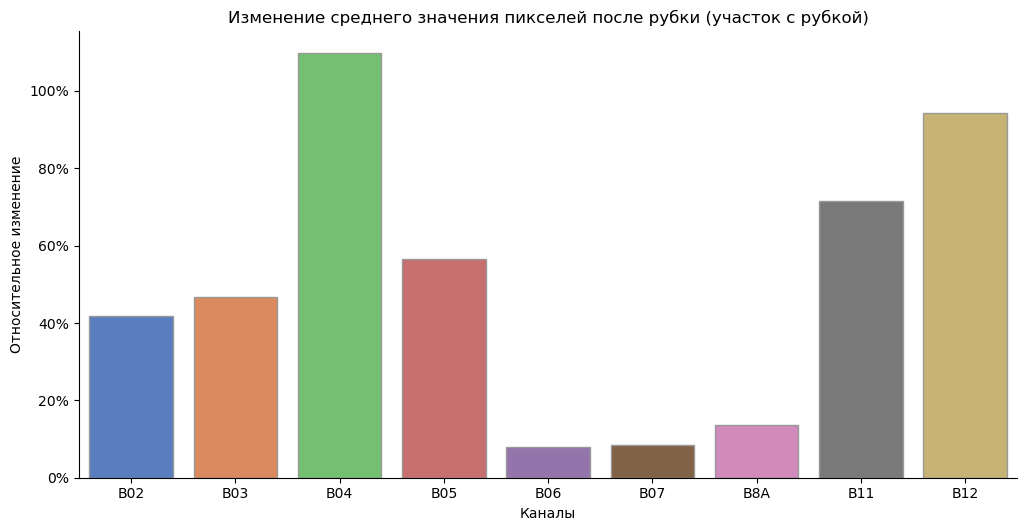

In [13]:
# строим график 1
sns.catplot(data=felling, x=felling.index, y='ratio', kind='bar', aspect=10/5, palette='muted', edgecolor='.6')
plt.xlabel('Каналы')
plt.ylabel('Относительное изменение')
plt.title('Изменение среднего значения пикселей после рубки (участок с рубкой)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.show()

На участке, где произошла рубка, средние значения пикселей увеличились у всех каналов, от 5% до 110%. Меньше всего изменились каналы B06, B07, B8A – рост не более 10%. Больше всего изменились каналы B04, B11, B12 – рост от 78% до 110%.

C:\Users\muratovin\Anaconda3\envs\da_practicum_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


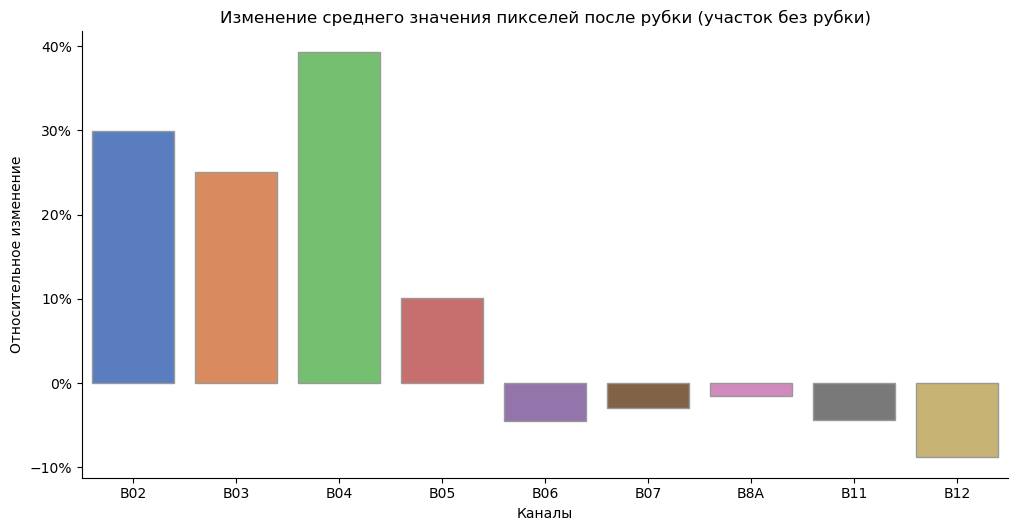

In [14]:
# строим график 2
sns.catplot(data=not_felling, x=not_felling.index, y='ratio', kind='bar', aspect=10/5, palette='muted', edgecolor='.6')
plt.xlabel('Каналы')
plt.ylabel('Относительное изменение')
plt.title('Изменение среднего значения пикселей после рубки (участок без рубки)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.show()

На остальных участках снимка наблюдается рост от 10% до 40% у каналов B02, B03, B04, B05, при этом остальные каналы демонстрируют отрицательную динамику, до -10%.

C:\Users\muratovin\Anaconda3\envs\da_practicum_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


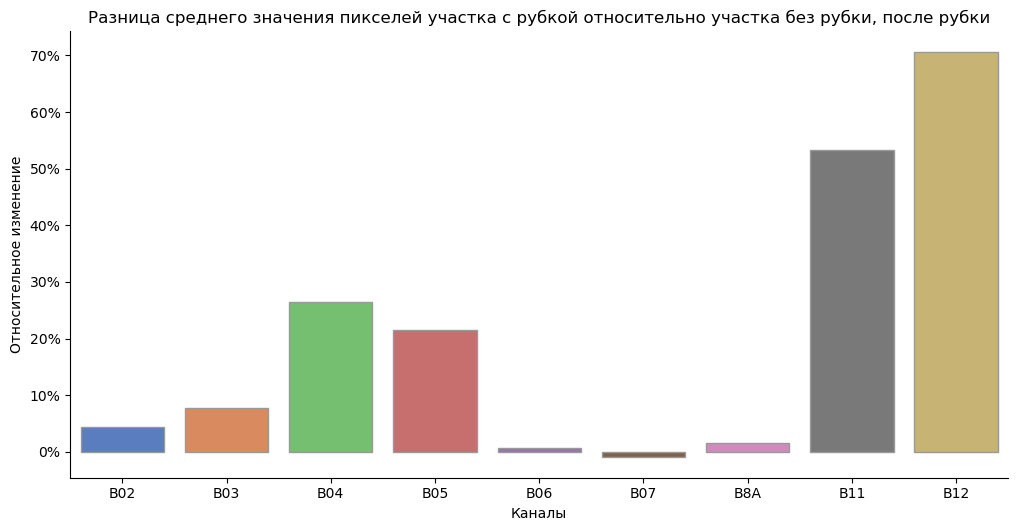

In [15]:
# строим график 3
sns.catplot(data=comparison, x=comparison.index, y='ratio', kind='bar', aspect=10/5, palette='muted', edgecolor='.6')
plt.xlabel('Каналы')
plt.ylabel('Относительное изменение')
plt.title('Разница среднего значения пикселей участка с рубкой относительно участка без рубки, после рубки')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.show()

При сравнении участков с рубкой и без рубки на снимке за август заметен рост каналов B11 и B12 – более 50%. Каналы B02, B03, B04, B05 показывают меньший рост – от 5% до 30%. Каналы B06, B07, B8A практически не изменяются.

**Выводы**

Все каналы снимка положительно реагируют на возникновение рубки – их средние значения растут. Однако, эта тенденция проявляется у каналов в разной степени. Наибольший отклик демонстрируют каналы B04, B11, B12. Меньше всего реагируют каналы B06, B07, B8A, которые могут рассматриваться как малоинформативные.

## Построение модели прогнозирования рубок

Ниже приведены расчеты только для сценария 1, расчеты по остальным сценариям имели те же параметры, но другие комбинации признаков.

In [16]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    #print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [17]:
%%time
# разделим наши данные на признаки (матрица X) и целевую переменную (y), признаки ограничиваются 1 и 99 перцентилем
X = data.drop(['felling'], axis = 1).apply(lambda col: winsorize(col, limits=[0.01, 0.01]), axis=0)
y = data['felling']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# обучим StandartScaler на обучающей выборке
scaler = MinMaxScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities, 
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Precision: 0.98
	Recall: 0.78
	F1: 0.87
	ROC_AUC: 0.99
CPU times: total: 27min 13s
Wall time: 27min 17s


In [18]:
# оценим важность признаков
features = pd.DataFrame(
    {'feature': X.columns,
    'coeff_rf': np.round(rf_model.feature_importances_, 3),}
)

# Переделываем таблицу в длинный вид
# features_melted = features.melt(id_vars=['feature'], value_vars=['coeff_lr', 'coeff_tree', 'coeff_rf', 'coeff_gb'], var_name='model', value_name='coeff')
features

,feature,coeff_rf
0,B02_old,0.026
1,B03_old,0.021
2,B04_old,0.044
3,B05_old,0.058
4,B06_old,0.031
5,B07_old,0.039
6,B8A_old,0.031
7,B11_old,0.056
8,B12_old,0.055
9,B02_new,0.094


C:\Users\muratovin\Anaconda3\envs\da_practicum_env\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


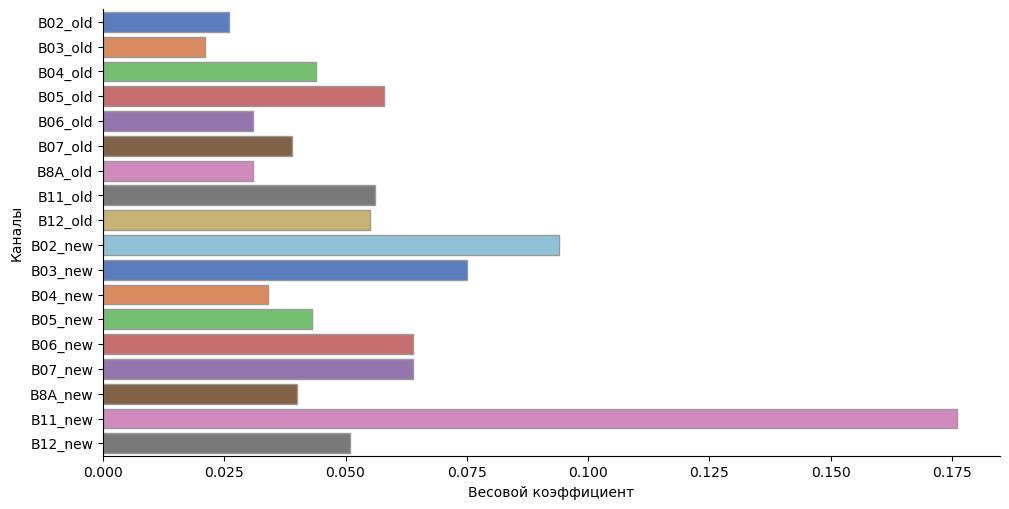

In [19]:
sns.catplot(data=features, x='coeff_rf', y='feature', aspect=10/5, kind='bar', palette='muted', edgecolor='.6')
plt.xlabel('Весовой коэффициент')
plt.ylabel('Каналы')
#plt.title(n)
    
plt.show()

In [23]:
%%time
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X_test = data_2017.apply(lambda col: winsorize(col, limits=[0.01, 0.01]), axis=0)
y_test = data_2017_felling['felling']

# Преобразуем набор 
X_test_st = scaler.transform(X_test)


# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities, 
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Precision: 0.96
	Recall: 0.49
	F1: 0.65
	ROC_AUC: 0.91
CPU times: total: 42.8 s
Wall time: 42.8 s


**Результаты**

Метрики по сценариям исследования

| <br><br> Сценарий | <br><br>	Precision |Producer <br><br> Recall | <br><br>	F1 | <br><br>	Precision |		User <br><br> Recall |	<br><br> F1 | <br><br> Время, мин |
|:---------:|:----------:|:--------:|:--------:|:---------:|:----------:|:--------:|:--------:|
| 1 |	0.98 | 	0.78 |	0.87 |	0.96 |	0.49 |	0.65 |	27 |
| 2 |	0.97 |	0.75 |	0.85 |	0.97 |	0.44 |	0.60 |	21 |
| 3	| 0.92 |	0.69 |	0.79 |	0.96 |	0.25 |	0.40 |	15 |
| 4	| 0.97 |	0.75 |	0.85 |	0.97 |	0.42 |	0.59 |	30 |
| 5	| 0.97 |	0.74 |	0.84 |	- |	- |	- |	21 |

При сравнении сценариев 1-3, которые содержат только каналы Sentinel-2, наибольшую точность показывает сценарий 1, но у него же и наибольшее затраченное время. Значительно меньшая точность у сценария 3, он же самый быстрый. Сценарий 2 имеет точность на 5% меньше и скорость обработки примерно на 30% быстрее, чем сценарий 1. Сценарии 4 и 5, имеющие дополнительные источники данных, не показали значимого прироста в точности прогноза.  

Для анализа из моделей взяты весовые коэффициенты и построены графики значений весовых коэффициентов. Каналы снимка за июль имеют окончание «_old», а за август – «_new».

![alt text for screen readers](fellings_scen_1.png "Сценарий 1")
![alt text for screen readers](fellings_scen_2.png "Сценарий 2")
![alt text for screen readers](fellings_scen_3.png "Сценарий 3")
![alt text for screen readers](fellings_scen_4.png "Сценарий 4")
![alt text for screen readers](fellings_scen_5.png "Сценарий 5")

## Выводы

Проведено исследование значимости спектральных каналов космических снимков Sentinel-2 на прогноз рубок в машинном обучении. В исследовании использован алгоритм машинного обучения «Случайный лес», который показал высокие результаты по основным метрикам на исходном датасете (Producer), но при этом низкую точность (метрика F1) на втором датасете (User). При этом по метрике Precision оценки остаются высокими, что говорит о том, что все найденные моделью рубки действительно являются рубками и ложноположительных срабатываний минимальное количество. При этом, метрика Recall сильно снижается на втором датасете – модель находит не все рубки, которые присутствуют в датасете, полнота определенных рубок менее 50%. Низкое значение метрики Recall также способствует снижению оценки F1.

Анализ весовых коэффициентов модели показывает, что наибольшую информативность имеют каналы с более позднего по дате съемки снимка (после рубки), что в свою очередь говорит о том, что модель строит свой прогноз в большей степени по данным со второго снимка. Однако использование пары снимков необходимо в целях недопущения ложных срабатываний на старые рубки, которые в большом количестве присутствуют на исследуемой территории. По результатам проведённого анализа значимости каналов Sentinel-2 для прогноза рубок по паре разновременных снимков можно сделать следующие выводы:

1.	В качестве наиболее значимых можно выделить следующие 6 спектральных каналов: B02, B03, B04, B05, B11, B12.
2.	Использование в модели машинного обучения дополнительных признаков в виде индексов, а также радиолокационных данных Sentinel-1 не показали прироста точности при выявлении лесных рубок.
